In [1]:
import numpy as np
import pandas as pd
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
zip = zipfile.ZipFile('dataset.zip')
zip.extractall()
zip.close

<bound method ZipFile.close of <zipfile.ZipFile filename='dataset.zip' mode='r'>>

About Dataset
The Human Activity Recognition database was built from the recordings of 30 study participants performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors. The objective is to classify activities into one of the six activities performed.  

Description of experiment
The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.



# Load Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB


In [5]:
train['subject'].value_counts()

subject
25    409
21    408
26    392
30    383
28    382
27    376
23    372
17    368
16    366
19    360
1     347
29    344
3     341
15    328
6     325
14    323
22    321
11    316
7     308
5     302
8     281
Name: count, dtype: int64

# Data Preprocessing

In [6]:
datasets = {'train' : train, 'test': test}
for i , j in datasets.items():
    print(f'Number of duplicates in {i} : {sum(j.duplicated())}')
for i , j in datasets.items():
    print(f'Number of missing values in {i} : {j.isna().values.sum()}')

Number of duplicates in train : 0
Number of duplicates in test : 0
Number of missing values in train : 0
Number of missing values in test : 0


## Class Imbalance

Text(0.5, 1.0, 'Plot of Activity')

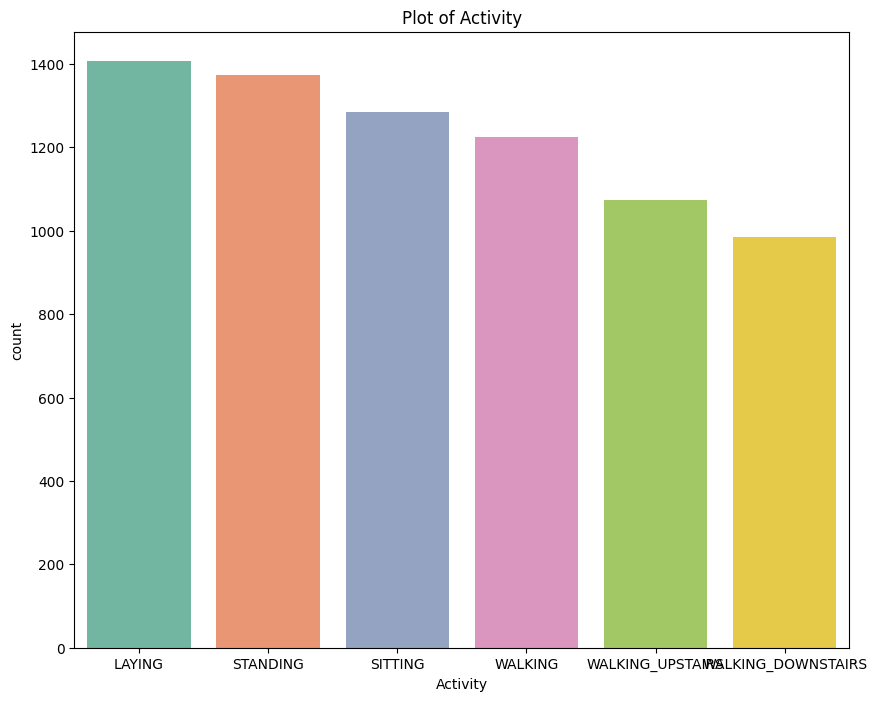

In [85]:
#train['Activity'].value_counts() (The values range across the same, so no imbalance problem)
plt.figure(figsize=(10,8))
sns.countplot(x=train['Activity'],order=train['Activity'].value_counts().index, palette='Set2')
plt.title('Plot of Activity')

# EDA

In [8]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [9]:
len(train.columns[train.columns.str.startswith('tBodyAcc-')])

40

In [10]:
train.columns[train.columns.str.startswith('angle(')]

Index(['angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)'],
      dtype='object')

In [11]:
train.columns[train.columns.str.startswith('fBodyBodyGyro')]

Index(['fBodyBodyGyroMag-mean()', 'fBodyBodyGyroMag-std()',
       'fBodyBodyGyroMag-mad()', 'fBodyBodyGyroMag-max()',
       'fBodyBodyGyroMag-min()', 'fBodyBodyGyroMag-sma()',
       'fBodyBodyGyroMag-energy()', 'fBodyBodyGyroMag-iqr()',
       'fBodyBodyGyroMag-entropy()', 'fBodyBodyGyroMag-maxInds',
       'fBodyBodyGyroMag-meanFreq()', 'fBodyBodyGyroMag-skewness()',
       'fBodyBodyGyroMag-kurtosis()', 'fBodyBodyGyroJerkMag-mean()',
       'fBodyBodyGyroJerkMag-std()', 'fBodyBodyGyroJerkMag-mad()',
       'fBodyBodyGyroJerkMag-max()', 'fBodyBodyGyroJerkMag-min()',
       'fBodyBodyGyroJerkMag-sma()', 'fBodyBodyGyroJerkMag-energy()',
       'fBodyBodyGyroJerkMag-iqr()', 'fBodyBodyGyroJerkMag-entropy()',
       'fBodyBodyGyroJerkMag-maxInds', 'fBodyBodyGyroJerkMag-meanFreq()',
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()'],
      dtype='object')

In [12]:
columns_df = pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in train.columns]),orient='Index').rename(columns = {0:"count"}).sort_values(by = 'count', ascending = False)
columns_df

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


## Analysing tBodyAccMag-mean feature


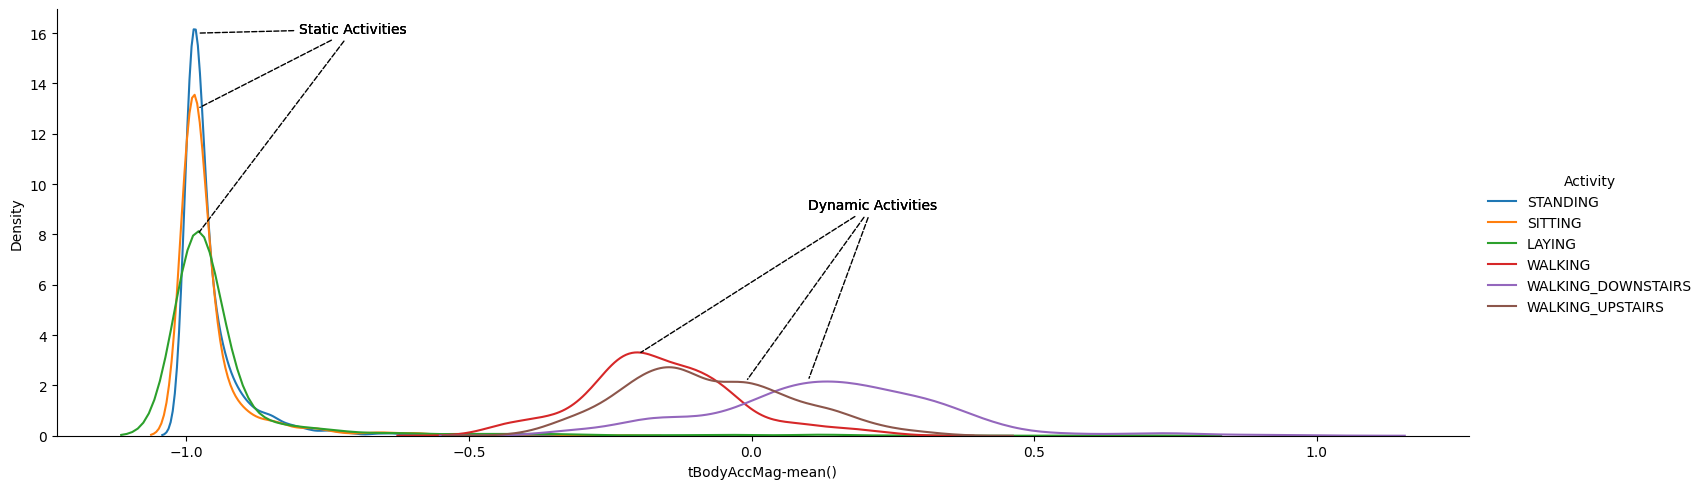

In [106]:
facetgrid = sns.FacetGrid(train, hue = 'Activity', height = 5, aspect = 3)
facetgrid.map(sns.distplot, 'tBodyAccMag-mean()', hist = False).add_legend()

plt.annotate("Static Activities", xy = (-.98, 8), xytext = (-.8, 16), arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Static Activities", xy = (-.98, 13), xytext = (-.8, 16), arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Static Activities", xy = (-.98, 16), xytext = (-.8, 16), arrowprops={'arrowstyle': '-', 'ls': 'dashed'})

plt.annotate("Dynamic Activities", xy=(-0.2,3.25), xytext=(0.1, 9),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Dynamic Activities", xy=(0.1,2.18), xytext=(0.1, 9),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})
plt.annotate("Dynamic Activities", xy=(-0.01,2.15), xytext=(0.1, 9),arrowprops={'arrowstyle': '-', 'ls': 'dashed'})

plt.show()

Seeing the above density plot it's clear that to separate static and dynamic activities we can use

if(tBodyAccMag-mean()<=-0.5):  
    Activity = "static"  
else:  
    Activity = "dynamic"

In [71]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


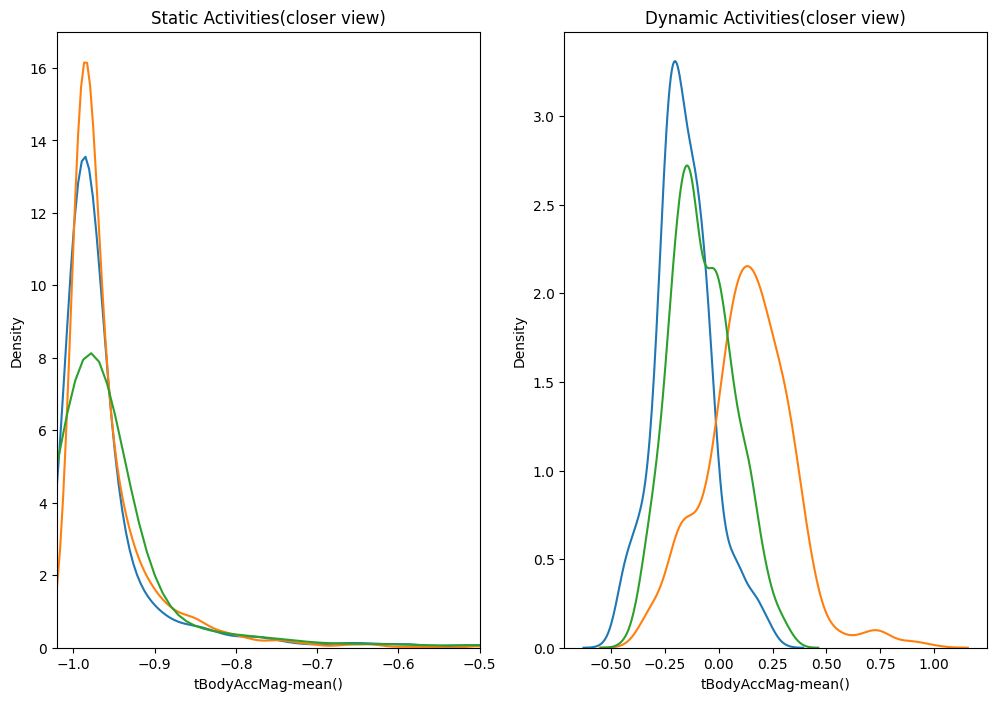

<Figure size 640x480 with 0 Axes>

In [101]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Static Activities(closer view)")
sns.distplot(train[train["Activity"]=="SITTING"]['tBodyAccMag-mean()'],hist = False, label = 'Sitting')
sns.distplot(train[train["Activity"]=="STANDING"]['tBodyAccMag-mean()'],hist = False,label = 'Standing')
sns.distplot(train[train["Activity"]=="LAYING"]['tBodyAccMag-mean()'],hist = False, label = 'Laying')
plt.axis([-1.02, -0.5, 0, 17])

plt.subplot(1,2,2)
plt.title("Dynamic Activities(closer view)")
sns.distplot(train[train["Activity"]=="WALKING"]['tBodyAccMag-mean()'],hist = False, label = 'WALKING')
sns.distplot(train[train["Activity"]=="WALKING_DOWNSTAIRS"]['tBodyAccMag-mean()'],hist = False,label = 'WALKING_DOWNSTAIRS')
sns.distplot(train[train["Activity"]=="WALKING_UPSTAIRS"]['tBodyAccMag-mean()'],hist = False, label = 'WALKING_UPSTAIRS')
plt.show()

The insights obtained through density plots can also be represented using Box plots. Let's plot the boxplot of Body Accelartion Magnitude mean(tBodyAccMag-mean()) across all the six categories.

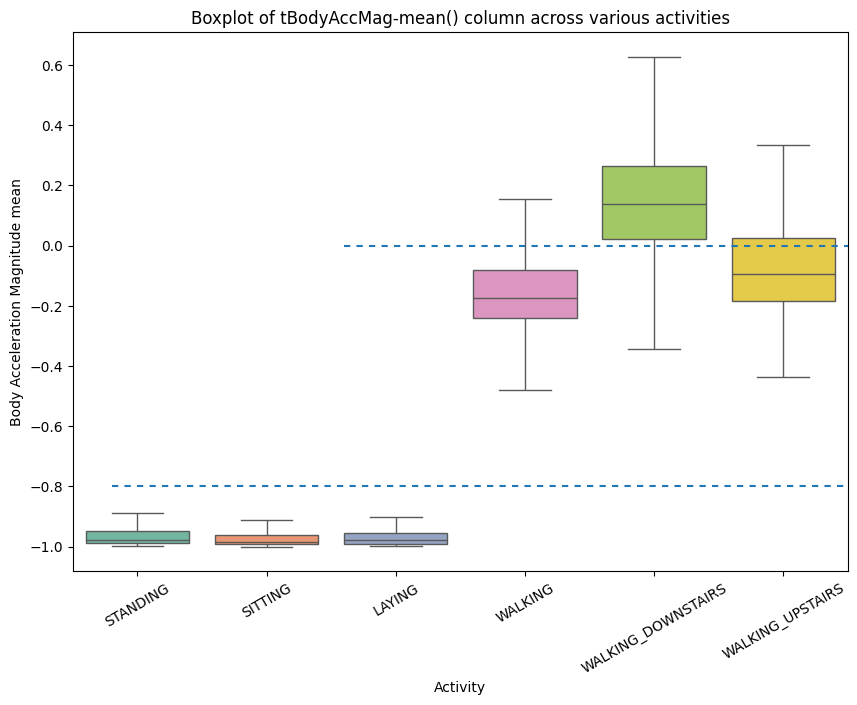

<Figure size 640x480 with 0 Axes>

In [88]:
plt.figure(figsize=(10,7))
sns.boxplot(x = "Activity", y="tBodyAccMag-mean()", data = train, showfliers = False, palette='Set2')
plt.ylabel('Body Acceleration Magnitude mean')
plt.title("Boxplot of tBodyAccMag-mean() column across various activities")
plt.axhline(y = -0.8, xmin = 0.05, dashes = (3,3))
plt.axhline(y= 0.0, xmin = 0.35, dashes=(3,3))
plt.xticks(rotation = 30)
plt.show()

Using boxplot again we can come with conditions to seperate static activities from dynamic activities.  

if(tBodyAccMag-mean()<=-0.8):  
    Activity = "static"  
if(tBodyAccMag-mean()>=-0.6):  
    Activity = "dynamic"  
    
Also, we can easily seperate WALKING_DOWNSTAIRS activity from others using boxplot.  
  
if(tBodyAccMag-mean()>0.02):  
    Activity = "WALKING_DOWNSTAIRS"  
else:  
    Activity = "others"  

## Analysing Angle between X-axis and gravityMean feature

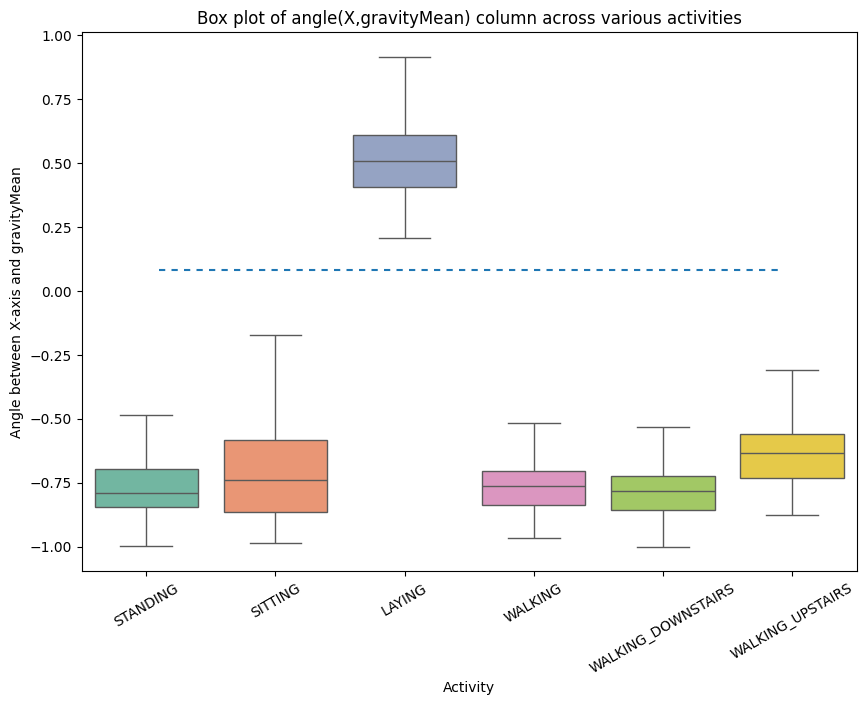

<Figure size 640x480 with 0 Axes>

In [89]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Activity', y='angle(X,gravityMean)', data=train, showfliers=False, palette='Set2')
plt.axhline(y=0.08, xmin=0.1, xmax=0.9,dashes=(3,3))
plt.ylabel("Angle between X-axis and gravityMean")
plt.title('Box plot of angle(X,gravityMean) column across various activities')
plt.xticks(rotation = 30)
plt.show()

From the boxplot we can observe that angle(X,gravityMean) perfectly seperates LAYING from other activities.  
  
if(angle(X,gravityMean)>0.01):  
    Activity = "LAYING"  
else:  
    Activity = "others"  

## Analysing Angle between Y-axis and gravityMean feature

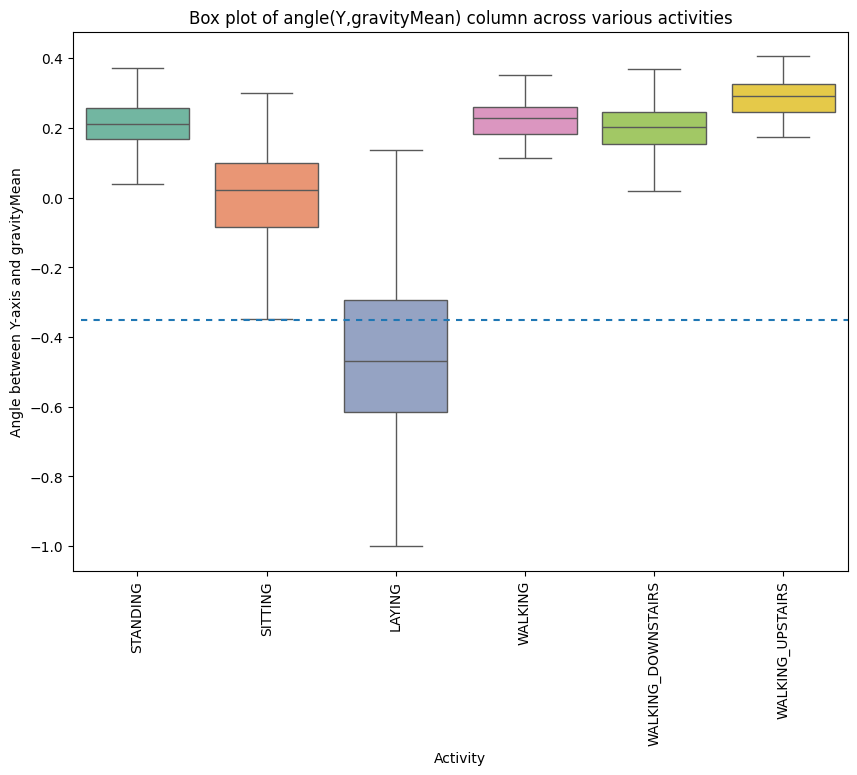

<Figure size 640x480 with 0 Axes>

In [90]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Activity', y='angle(Y,gravityMean)', data = train, showfliers=False, palette='Set2')
plt.ylabel("Angle between Y-axis and gravityMean")
plt.title('Box plot of angle(Y,gravityMean) column across various activities')
plt.xticks(rotation = 90)
plt.axhline(y=-0.35, xmin=0.01, dashes=(3,3))
plt.show()

Similarly, using Angle between Y-axis and gravityMean we can seperate LAYING from other activities but again it leads to some misclassification error.

# Visualizing data using PCA

In [23]:
x_for_pca = train.drop(['subject', 'Activity'], axis= 1)
pca =  PCA(n_components=2, random_state=0).fit_transform(x_for_pca)

In [28]:
pca[:,0]

array([-5.5202803 , -5.53534954, -5.47498801, ...,  5.85750527,
        5.42109482,  5.49797027])

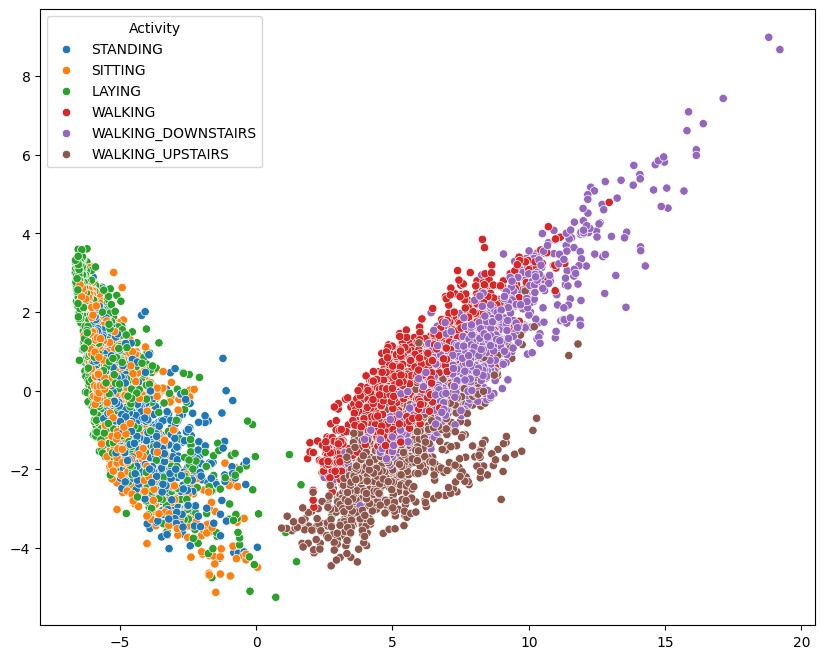

<Figure size 640x480 with 0 Axes>

In [91]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=pca[:,0], y = pca[:,1], hue=train['Activity'])
plt.show()

Using the two new components obtained through PCA we can visualize and seperate all the six activities in a 2D space.

## Visualizing data using t-SNE

In [31]:
x_for_tsne = train.drop(['subject', 'Activity'], axis= 1)
tsne = TSNE(n_components=2, random_state=0, n_iter=1000).fit_transform(x_for_tsne)


  File "C:\Users\karti\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


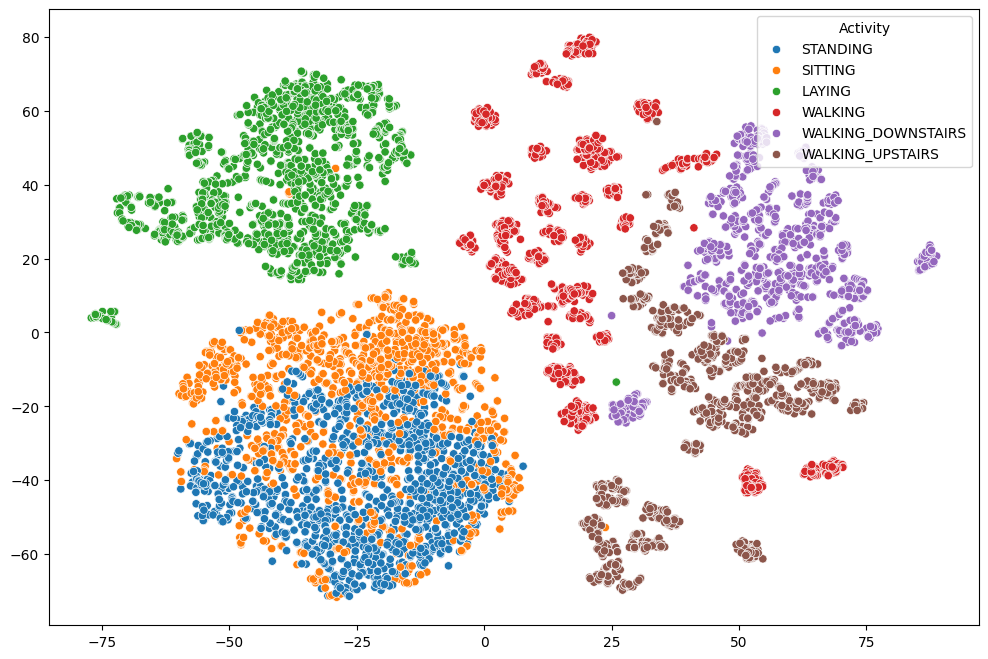

<Figure size 640x480 with 0 Axes>

In [92]:
plt.figure(figsize=(12,8))
sns.scatterplot(x = tsne[:, 0], y = tsne[:, 1], hue = train['Activity'])
plt.show()

# training and test data

In [38]:
x_train = train.drop(['subject', 'Activity'], axis = 1)
y_train = train.Activity

x_test = test.drop(['subject', 'Activity'], axis = 1)
y_test = test.Activity

In [39]:
print('Training data size : ', x_train.shape)
print('Test data size : ', x_test.shape)

Training data size :  (7352, 561)
Test data size :  (999, 561)


## Logistic regression model with Hyperparameter tuning and cross validation

In [40]:
parameters = {'max_iter':[100,200,500]}
lr_classifier = LogisticRegression()
lr_classifier_rs = RandomizedSearchCV(lr_classifier,param_distributions=parameters, cv = 5, random_state=42)
lr_classifier_rs.fit(x_train, y_train)
y_pred_lr = lr_classifier_rs.predict(x_test)

In [45]:
lr_accuracy  = accuracy_score(y_true=y_test, y_pred=y_pred_lr)
print(f'Accuracy using Logistic Regression : {round(lr_accuracy*100,3)}')

Accuracy using Logistic Regression : 95.495


In [46]:
# function to plot confusion matrix
def plot_confusion_matrix(cm,labels):
    fig, ax = plt.subplots(figsize=(12,8)) # for plotting confusion matrix as image
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=labels, yticklabels=labels,
    ylabel='True label',
    xlabel='Predicted label')
    plt.xticks(rotation = 90)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]),ha="center", va="center",color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

In [47]:
cm = confusion_matrix(y_test.values,y_pred_lr)
cm

array([[183,   0,   0,   0,   0,   0],
       [  0, 147,  20,   0,   0,   3],
       [  0,   8, 169,   1,   0,   0],
       [  0,   0,   0, 185,   0,   0],
       [  0,   0,   0,   0, 134,   0],
       [  0,   0,   0,  13,   0, 136]], dtype=int64)

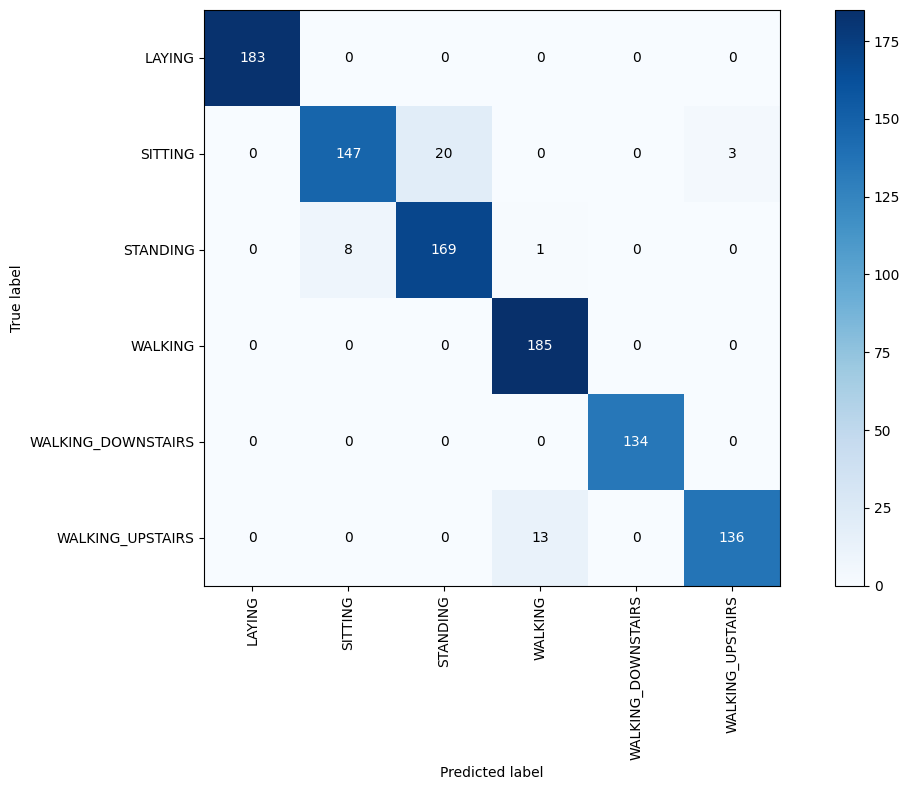

In [48]:
cm = confusion_matrix(y_test.values,y_pred_lr)
plot_confusion_matrix(cm, np.unique(y_pred_lr))

In [49]:
#function to get best random search attributes
def get_best_randomsearch_results(model):
    print("Best estimator : ", model.best_estimator_)
    print("Best set of parameters : ", model.best_params_)
    #print("Best score : ", model.best_score_)

In [50]:
# getting best random search attributes
get_best_randomsearch_results(lr_classifier_rs)

Best estimator :  LogisticRegression(max_iter=200)
Best set of parameters :  {'max_iter': 200}


## Kernel SVM model with Hyperparameter tuning and cross validation

In [51]:
parameters = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [100, 50]
}

svm_rs = RandomizedSearchCV(SVC(), param_distributions=parameters, cv = 3, random_state=42)
svm_rs.fit(x_train, y_train)

RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': [100, 50],
                                        'kernel': ['linear', 'rbf', 'poly',
                                                   'sigmoid']},
                   random_state=42)

In [52]:
y_pred = svm_rs.predict(X_test)

In [53]:
kernel_svm_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"Accuracy using Kernel SVM : {round(kernel_svm_accuracy*100,2)} ")

Accuracy using Kernel SVM : 96.6 


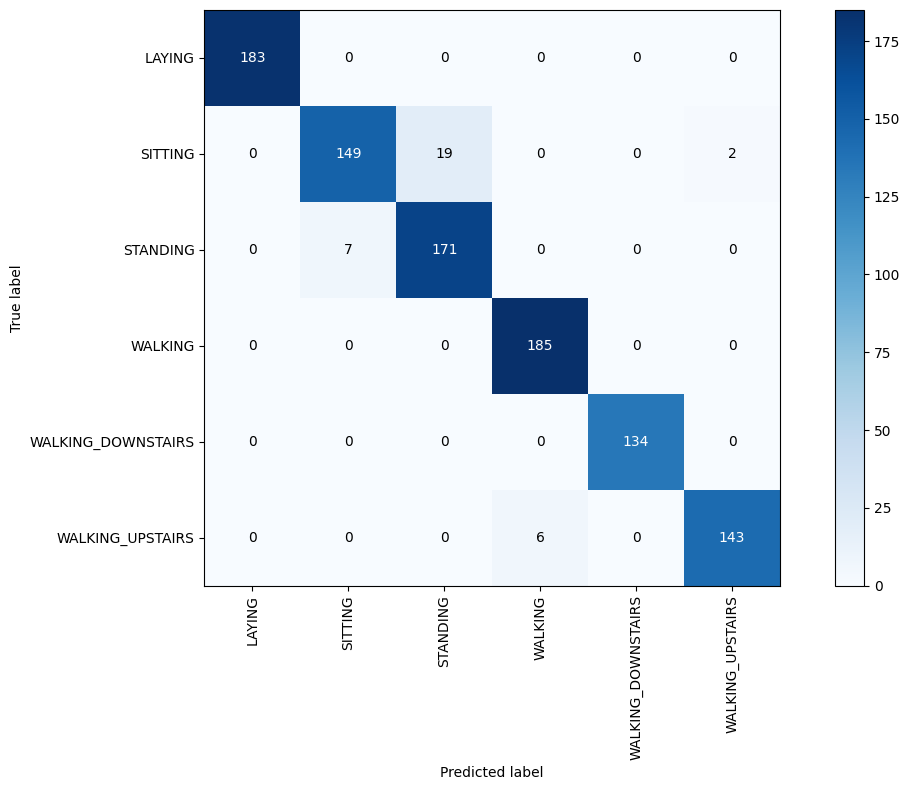

In [54]:
cm = confusion_matrix(y_test.values,y_pred)
plot_confusion_matrix(cm, np.unique(y_pred))

In [55]:
get_best_randomsearch_results(svm_rs)

Best estimator :  SVC(C=50)
Best set of parameters :  {'kernel': 'rbf', 'C': 50}


## Decision tree model with Hyperparameter tuning and cross validation

In [57]:
parameters = {'max_depth': np.arange(2, 10, 2)}

dt_classifier = DecisionTreeClassifier()
dt_classifier_rs = RandomizedSearchCV(dt_classifier, param_distributions = parameters, random_state = 42)
dt_classifier_rs.fit(x_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                   param_distributions={'max_depth': array([2, 4, 6, 8])},
                   random_state=42)

In [58]:
y_pred_dt = dt_classifier_rs.predict(x_test)

In [60]:
dt_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_dt)
print(f"Accuracy using Decision tree : {round(dt_accuracy*100,2)}")

Accuracy using Decision tree : 85.09


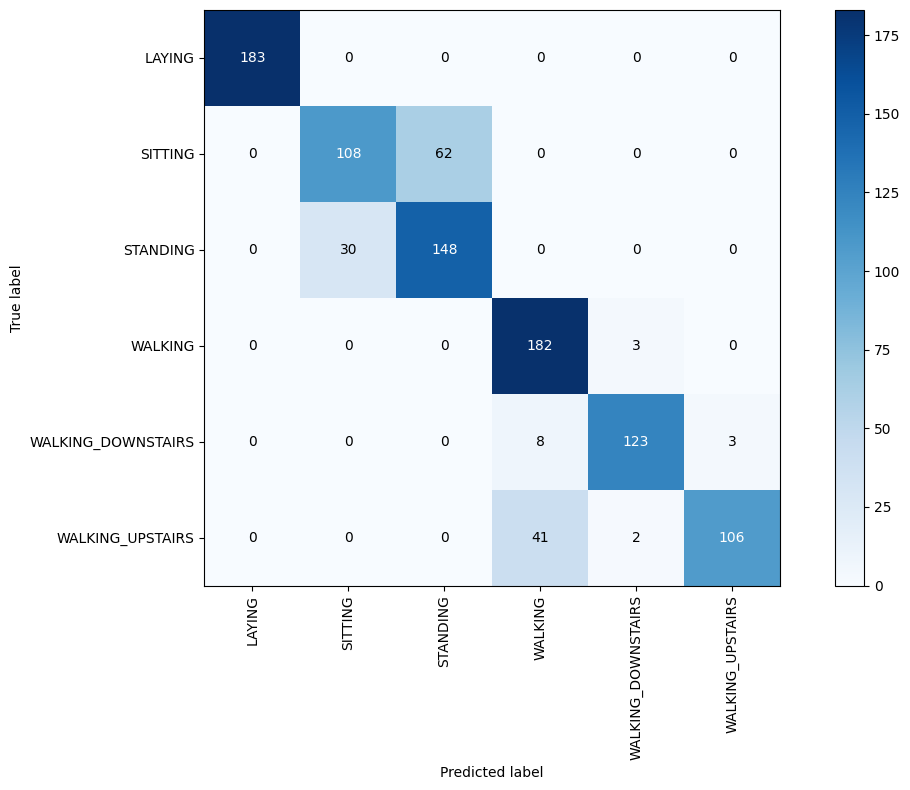

In [61]:
cm = confusion_matrix(y_test.values,y_pred_dt)
plot_confusion_matrix(cm, np.unique(y_pred_dt))

In [62]:
get_best_randomsearch_results(dt_classifier_rs)

Best estimator :  DecisionTreeClassifier(max_depth=8)
Best set of parameters :  {'max_depth': 8}


## Random forest model with Hyperparameter tuning and cross validation

In [63]:
parameters = {
    'n_estimators':np.arange(20, 101, 10), 
    'max_depth': np.arange(2, 17, 2)
}
rf_classifier = RandomForestClassifier()
rf_classifier_rs = RandomizedSearchCV(rf_classifier, param_distributions=parameters,random_state = 42)
rf_classifier_rs.fit(x_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16]),
                                        'n_estimators': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100])},
                   random_state=42)

In [64]:
get_best_randomsearch_results(rf_classifier_rs)

Best estimator :  RandomForestClassifier(max_depth=14)
Best set of parameters :  {'n_estimators': 100, 'max_depth': 14}


In [65]:
y_pred_rf = rf_classifier_rs.predict(x_test)

In [67]:
rf_accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_rf)
print(f"Accuracy using Random Forest : {round(rf_accuracy*100,2)}")

Accuracy using Random Forest : 92.09


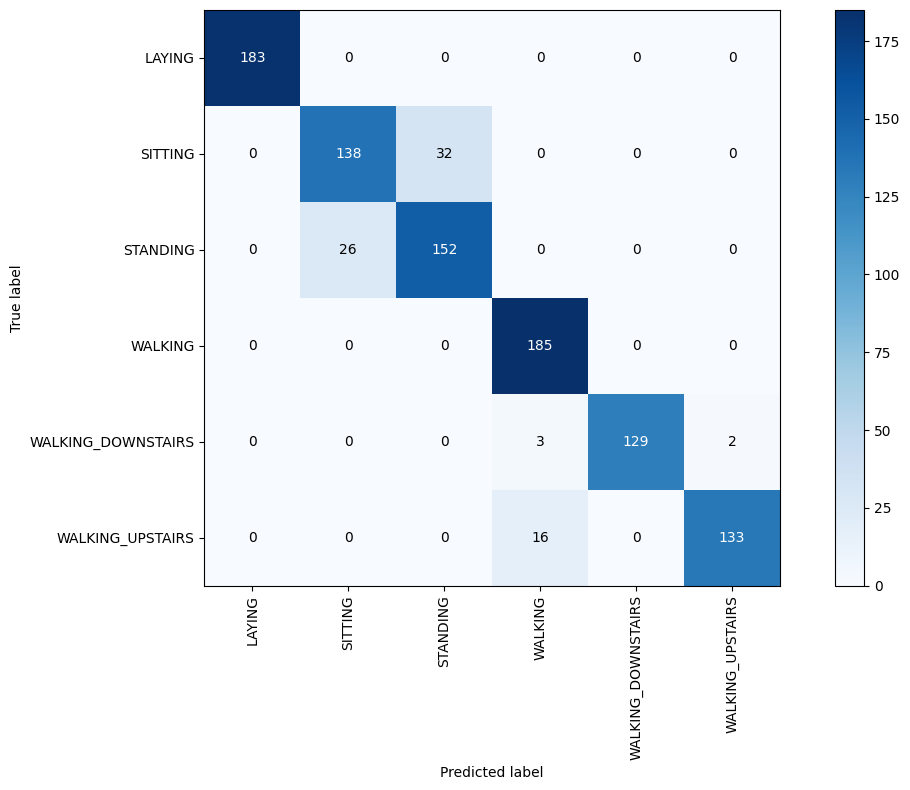

In [68]:
cm = confusion_matrix(y_test.values,y_pred_rf)
plot_confusion_matrix(cm, np.unique(y_pred_rf))